# Step 2: Controlled Generation of Small Molecules with `GenMol`

### RORc Nuclear Receptor Antagonist Case-Study
Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

[GenMol](https://arxiv.org/abs/2501.06158) is a masked diffusion model trained on molecular [Sequential Attachment-based Fragment Embedding (SAFE)](https://arxiv.org/abs/2310.10773) representations for fragment-based molecule generation. GenMol can serve as a generalist model for various drug discovery tasks, including *de novo* molecular generation​, linker design​, motif extension​, scaffold decoration/morphing​, hit generation​, and lead optimization.

## 2.1 Set Up the Environment

In [1]:
!pip install rdkit python-dotenv pandas numpy matplotlib loguru py3dmol safe-mol datamol


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.4/495.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [3]:
import pickle
import numpy as np
import pandas as pd
import random
import os, shutil, requests
import matplotlib.pyplot as plt
from typing import List
from IPython.display import display, clear_output

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.QED import qed
from google.colab import userdata

# SAFE to SMILES conversion
import safe as sf
import datamol as dm

In [4]:
class Slicer:
    def __call__(self, mol):
        if isinstance(mol, str):
            mol = Chem.MolFromSmiles(mol)

        bonds = mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]'))
        for bond in bonds:
            yield bond

class Utils:

    @staticmethod
    def cut(smiles):
        def cut_nonring(mol):
            if not mol.HasSubstructMatch(Chem.MolFromSmarts('[*]-;!@[*]')):
                return None

            bis = random.choice(mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]')))  # single bond not in ring
            bs = [mol.GetBondBetweenAtoms(bis[0], bis[1]).GetIdx()]
            fragments_mol = Chem.FragmentOnBonds(mol, bs, addDummies=True, dummyLabels=[(1, 1)])

            try:
                return Chem.GetMolFrags(fragments_mol, asMols=True, sanitizeFrags=True)
            except ValueError:
                return None

        mol = Chem.MolFromSmiles(smiles)
        frags = set()

        for _ in range(3):
            frags_nonring = cut_nonring(mol)
            if frags_nonring is not None:
                frags |= set([Chem.MolToSmiles(f) for f in frags_nonring])

        return frags

    @staticmethod
    def attach(frag1, frag2):
        rxn = AllChem.ReactionFromSmarts('[*:1]-[1*].[1*]-[*:2]>>[*:1]-[*:2]')
        mols = rxn.RunReactants((Chem.MolFromSmiles(frag1), Chem.MolFromSmiles(frag2)))
        return None if len(mols) == 0 else Chem.MolToSmiles(mols[np.random.randint(len(mols))][0])

    @staticmethod
    def smiles2safe(smiles):
        return sf.SAFEConverter(ignore_stereo=True).encoder(smiles, allow_empty=True)

    @staticmethod
    def attachable_points(fragment):
        return sf.utils.list_individual_attach_points(Chem.MolFromSmiles(fragment), depth=3)

## 2.2 Define the `SEED` Molecule

Example ligand based on **Compd 2** in Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

**Compd 2** was an antagonist with a RORc SRC1 EC<SUB>50</SUB> = 57 nM (-96% efficacy)

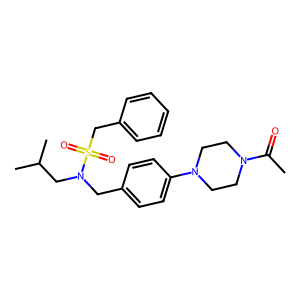

In [23]:
parent_ligand = "CC(C)CN(Cc1ccc(cc1)N2CCN(CC2)C(C)=O)[S](=O)(=O)Cc3ccccc3"
parent_mol = dm.to_mol(parent_ligand)
display(dm.to_image(parent_mol))

### Create modified SMILES, with "Fe" as exploration point on `SEED`

Ligand drawn with https://molview.org/ and exported as canonical SMILES string.

Set the exploration point at "Fe" so it is easy to find and edit in the resulting SMILES.


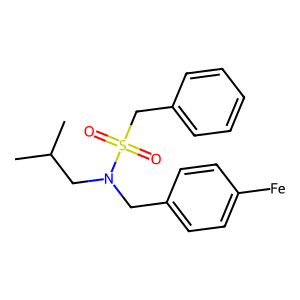

In [30]:
seed_smiles = "CC(C)CN(Cc1ccc([Fe])cc1)[S](=O)(=O)Cc2ccccc2"
seed_mol = dm.to_mol(seed_smiles)
display(dm.to_image(seed_mol))

In [31]:
safe_str = sf.encode(seed_mol)
print(f"SMILES: {seed_smiles}")
print(f"SAFE:   {safe_str}\n represented using {len(safe_str.split('.'))} fragments")

SMILES: CC(C)CN(Cc1ccc([Fe])cc1)[S](=O)(=O)Cc2ccccc2
SAFE:   c15cc[c]([Fe])cc1.c16ccccc1.S4(=O)(=O)C6.CC(C)C2.N234.C35
 represented using 6 fragments


### Ensure `safe` and `datamol` are functioning correctly

Reconstruct the fragments to ensure reconstruction matches original input

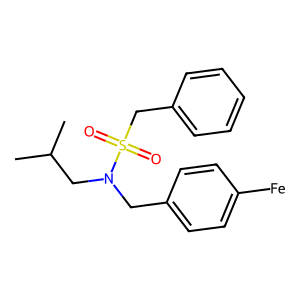

In [9]:
testreconstructed = dm.to_mol(safe_str)
display(dm.to_image(testreconstructed))

### Visualize `safe` deconstruction of SMILES into fragments

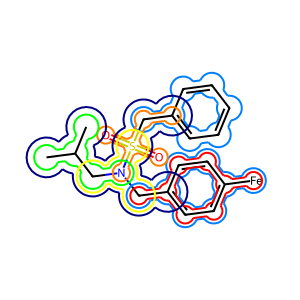

In [10]:
sf.to_image(safe_str)

### Edit SMILES of parent ligand to enable `GenMol`

Replace `[Fe]` in SMILES string with `[2*]`

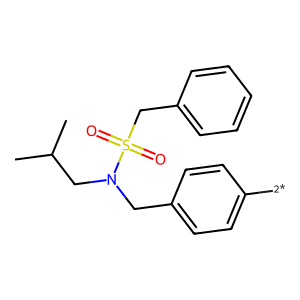

In [11]:
smiles = 'CC(C)CN(Cc1ccc([2*])cc1)[S](=O)(=O)Cc2ccccc2'
Draw.MolToImage(Chem.MolFromSmiles(smiles))

In [12]:
safe = Utils.smiles2safe(smiles)
safe

'c17ccc3cc1.c18ccccc1.S6(=O)(=O)C8.CC(C)C4.N456.C57'

### Create the `safe` SMILES with the generation/edit point included

In [13]:
smiles = safe + '.[*{15-35}]'
smiles

'c17ccc3cc1.c18ccccc1.S6(=O)(=O)C8.CC(C)C4.N456.C57.[*{15-35}]'

## 2.3 Configure the `GenMol` API

NOTE: Be sure to follow the steps in the [README](https://github.com/bf-nv/bionemo_tutorials/blob/main/README.md) to embed your NVIDIA `API_KEY` into your Google Colab environment.

In [14]:
API_KEY = userdata.get('API_KEY')
# print(API_KEY)

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}

invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/genmol/generate"

session = requests.Session()

## 2.4 Connect to the `GenMol` API and collect the results

In [15]:
payload = {
    "smiles": smiles,
    "num_molecules": 100,
    "temperature": 2,
    "noise": 0.5,
    "step_size": 1,
    "scoring": "QED"
}

# re-use connections
session = requests.Session()

response = session.post(invoke_url, headers=headers, json=payload)

response.raise_for_status()
result = response.json()
print(result)

{'status': 'success', 'molecules': [{'smiles': 'CC(C)CN(Cc1ccc(C(N)=O)cc1)S(=O)(=O)Cc1ccccc1', 'score': 0.786}, {'smiles': 'CC(C)CN(Cc1ccc(C(=O)O)cc1)S(=O)(=O)Cc1ccccc1', 'score': 0.782}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.78

### Determine similarities between `SEED` and generated ligands

In [16]:
def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    fingerprint_radius_param = 2
    fingerprint_nbits = 2048

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = GetMorganFingerprintAsBitVect(
        reference_mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits
    )

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

In [19]:
unique_molecules = {mol['smiles']: mol['score'] for mol in result['molecules']}
smiles_list = list(unique_molecules.keys())
qed_list = list(unique_molecules.values())

tanimoto_list = []
for smile in smiles_list:
  tanimoto_list.append(tanimoto_similarity(smile, ))

18

In [ ]:
gen_tanimoto = [round(_, 2) for _ in gen_tanimoto]
gen_clogp = [round(_, 2) for _ in smiles_list]

df_viz = pd.DataFrame({
    'smiles': gen_smiles,
    'minsim': gen_minsims,
    'tanimoto': gen_tanimoto,
    'clogp': gen_clogp
})
df_viz = df_viz.sort_values(
    by=['tanimoto', 'minsim', 'clogp'],
    ascending=[False, False, True])
df_viz.head()

In [17]:
# Create a dictionary to store the results for this min_sim
gen_results = {'smiles': [], 'tanimoto_similarity': [], 'qed_score': []}

unique_molecules = {mol['smiles']: mol['score'] for mol in result['molecules']}
smiles_list = list(unique_molecules.keys())
qed_list = list(unique_molecules.values())

# Calculate Tanimoto similarity for each SMILES
tanimoto_similarity = []

for smiles in smiles_list:
    tanimoto = tanimoto_similarity(smiles, seed_mol)
    tanimoto_similarity.append(tanimoto)


TypeError: 'list' object is not callable

### Visualize the results

**Note:** only keeping the unique results, duplicates are omitted

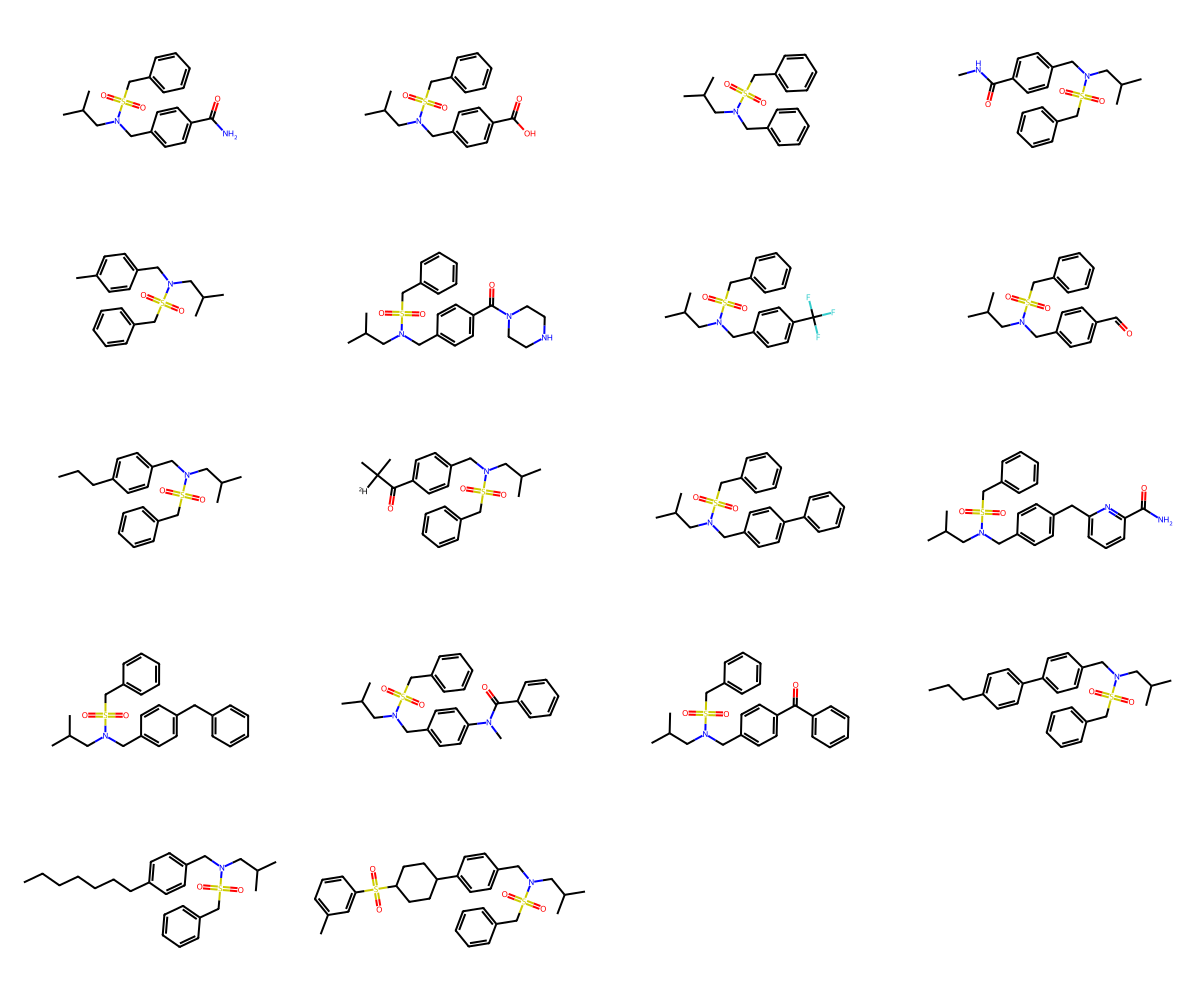

In [18]:
ms = [Chem.MolFromSmiles(_) for _ in smiles_list]
Draw.MolsToGridImage(ms,
                     molsPerRow=4,
                     subImgSize=(300, 200),
                     legends = [f"QED {qed}\nTanimoto to SEED {tanimoto}" for qed, tanimoto in zip(qed_list, tanimoto_similarity)]
                     )

## 2.5 Preprocess the Generated Small Molecules for use in `DiffDock`

In [ ]:
# choose the first N molecules from the individual runs to use for docking,
# for demo purpose we will set it to 5 for now.
N_molecules_for_docking = 5

# for each sublists, choose the first N molecules
molecules = [
    molecule
    for min_sim_key, min_sim_val in results.items()
    for molecule in min_sim_val['smiles'][:N_molecules_for_docking]
]
print(molecules)

In [ ]:
def prepare_output_directory(output):
    """
    Prepare the output directory
    output: str, the output directory
    return: None
    """
    # overwrite the output directory
    if os.path.exists(output):
        shutil.rmtree(output)
    os.makedirs(output)

Convert SMILES to SDF (generate 1 conformer for each SMILES)

In [ ]:
output_dir = "/content/output/genmol_result"
output_dir_clean = os.path.join(output_dir, "clean_mols")
prepare_output_directory(output_dir_clean)

# convert to SDF
output_sdf_files = []
for i, smiles in enumerate(molecules):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    img = Draw.MolToImage(mol, size=(150, 150))
    display(img)

    # save the clean file
    path = f"{output_dir_clean}/molecule_{i}.sdf"
    w = Chem.SDWriter(path)
    w.write(mol)
    w.close()
    print(f"Converted SMILES to SDF: {smiles}")
    output_sdf_files.append(path)

# here are the paths to the generated molecules in SDF format, which can be used for docking
print(output_sdf_files)

### Download SDF files which need to be uploaded in Step 3 - Using DiffDock to Predict Docking Poses

In [ ]:
# Step 1: Zip the directory
zip_filename = "clean_mols.zip"
!cd {output_dir_clean} && zip -r {zip_filename} .

In [ ]:
# Step 2: Download the zipped file
from google.colab import files
files.download(os.path.join(output_dir_clean, zip_filename))